# Решение задачи чемпионата Курской области Цифровой прорыв 2022
## Цель:
Разработать классификатор для автоматического определения категории запроса по тексту сообщения, оставленному на сайте Администрации Курской области. Условие - для обучения модели классификации не использовать колонку "Тематика".

---

## Загрузим нужные библиотеки

---



In [116]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [117]:
pip install pyaspeller

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [118]:
pip install autocorrect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [119]:
pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download("punkt")
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

from typing import Dict, List
from collections import defaultdict
import random

from autocorrect import Speller
from pymorphy2 import MorphAnalyzer
import pandas as pd
import numpy as np
import re
from sklearn.metrics import roc_auc_score


from tensorflow.keras import utils 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from google.colab import drive 
import time 
from tensorflow.keras.callbacks import ModelCheckpoint 
from keras.models import load_model 
import re 
import seaborn as sns 

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [121]:
PATH = 'drive/MyDrive/dataset/'

In [122]:
df_train = pd.read_csv(PATH+'train_dataset_train.csv', sep=',')
df_test = pd.read_csv(PATH+'test_dataset_test.csv', sep=',') 

In [123]:
df_train.head(10)

,id,Текст Сообщения,Тематика,Ответственное лицо,Категория
0,2246,Помогите начальник Льговского рэс не реагирует...,"Нарушения, связанные с содержанием электросети...",Администрация Льговского района,3
1,380,<p>По фасаду дома по адресу ул. Урицкого 22 пр...,Аварийные деревья,Администрация города Курска,3
2,2240,Агресивные собаки. На радуге там стая из подро...,Безнадзорные животные,Администрация города Курска,1
3,596,<p>На пересечении &nbsp;улиц Сосновская и Бере...,Нескошенная сорная растительность в местах общ...,Комитет дорожного хозяйства города Курска,3
4,1797,<p style=`text-align:justify;`><span style=`ba...,Аварийные деревья,Комитет городского хозяйства города Курска,3
5,1383,<p>Добрый день! Управляющая Компания “Аврора +...,Несвоевременная очистка дворовой территории мн...,Комитет жилищно-коммунального хозяйства города...,3
6,1934,"Добрый день, полностью отсутствует наружнее ос...",Неработающее наружное освещение,Администрация города Курска,3
7,2833,Едкий и вредный для здоровья запах от карьеров...,Неприятные запахи,Комитет природных ресурсов Курской области,16
8,1263,<p>Отсутствие люка</p>,Отсутствие люков на коммуникационных колодцах,Муниципальное казенное учреждение «Городская и...,3
9,1593,<p>Добрый день.&nbsp;</p><p>На остановке `Площ...,Пешеходные переходы на дорогах в границах горо...,Комитет природных ресурсов Курской области,0


In [124]:
df_test.head()

,id,Текст Сообщения,Тематика,Ответственное лицо
0,843,<p>Здравствуйте. На улице Мира &nbsp;было заме...,Неработающее наружное освещение,Администрация Курчатовского района
1,1422,<p>Уже вторую неделю не горит уличное освещени...,Неработающее наружное освещение,Комитет жилищно-коммунального хозяйства города...
2,2782,Не работает освещение во дворе дома 11а по Эне...,Неработающее наружное освещение,Комитет жилищно-коммунального хозяйства города...
3,2704,После покоса сорной растительности на газоне м...,Неудовлетворительная уборка улиц и тротуаров,Администрация Центрального округа города Курска
4,1,<p>Прошу принять меры к водителю маршрута 263:...,Неудовлетворительный внешний вид (поведение) в...,Администрация города Курска


In [126]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  2000 non-null   int64 
 1   Текст Сообщения     2000 non-null   object
 2   Тематика            2000 non-null   object
 3   Ответственное лицо  2000 non-null   object
 4   Категория           2000 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 78.2+ KB


In [127]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  1000 non-null   int64 
 1   Текст Сообщения     1000 non-null   object
 2   Тематика            1000 non-null   object
 3   Ответственное лицо  1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB


## Посмотрим на таргеты
### Тематика

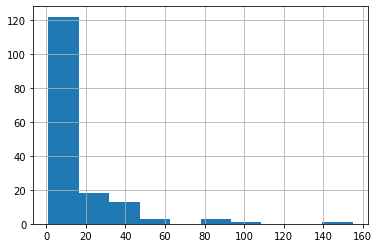

In [128]:
df_train["Тематика"].value_counts().hist()

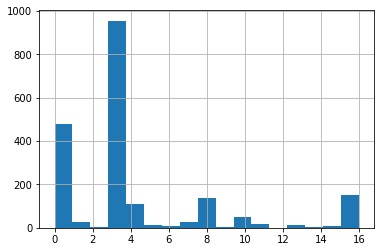

In [129]:
df_train["Категория"].hist(bins = 17) 

In [130]:
df_train["Ответственное лицо"].value_counts()

Администрация города Курска                                          421
Комитет дорожного хозяйства города Курска                            215
Комитет жилищно-коммунального хозяйства города Курска                171
Государственная жилищная инспекция Курской области                   151
Комитет городского хозяйства города Курска                           127
                                                                    ... 
МКУ «Управление по делам ГО и ЧС при Администрации города Курска»      1
Комитет агропромышленного комплекса Курской области                    1
Комитет информации и печати Курской области                            1
Администрация Кореневского района                                      1
ООО `УК `Северный дом`                                                 1
Name: Ответственное лицо, Length: 75, dtype: int64

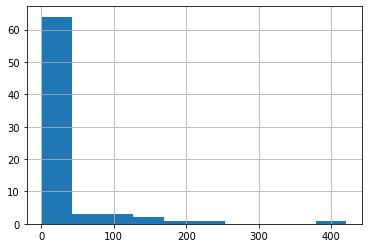

In [131]:
df_train["Ответственное лицо"].value_counts().hist()

## Убедимся, что одной тематике соответствует одна и та же категория

---



In [163]:
df_train_grp_theme = df_train.groupby('Тематика')
df_train_grp_theme = df_train_grp_theme['Категория'].agg([('cat_min', 'min'), ('cat_max', 'max'), ('theme_count', 'count')])
np.sum(df_train_grp_theme.cat_min != df_train_grp_theme.cat_max)

0

## Проверим количество тем в записях

---



In [164]:
df_train_grp_theme.theme_count.sort_values(axis=0, ascending=True).head(50)

Тематика
Нарушения в вопросах оплаты коммунальных услуг в микрорайонах ИЖС                                                                       1
Нарушения, связанные с обеспечением детским питанием                                                                                    1
Неудовлетворительное качество работы преподавателей и другого персонала учреждения дополнительного образования                          1
Нарушение графика движения при осуществлении внутриобластных междугородных перевозок                                                    1
Нарушение графика движения при осуществлении муниципальных (пригородных) перевозок                                                      1
Недостаточное обеспечение кадрами учреждений здравоохранения                                                                            1
Отказ в вакцинации                                                                                                                      1
Недостаточное количество 

## Связь категории и ответственного лица

Добавим колонку с типом ответственного лица

---



In [165]:
df_train['Тип ответственного'] = df_train['Ответственное лицо'].apply(lambda x: 'Администрация' if x[:13] == 'Администрация'                                                                      else 'Комитет' if x[:7] == 'Комитет' else 'Другое')
pd.crosstab(df_train['Тип ответственного'], df_train['Категория'])

Категория,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Тип ответственного,,,,,,,,,,,,,,,,,
Администрация,280,11,1,369,0,9,5,13,53,0,12,11,0,6,1,2,76
Другое,3,0,0,242,2,0,0,0,19,0,1,1,1,1,0,0,3
Комитет,195,14,2,343,106,3,5,14,67,5,35,7,0,4,3,5,70


Зависимости между категорией и ответственным лицом города не наблюдается

Видоизменим категорию "Тематика"

In [166]:
df_train["Длина Сообщения"] = train["Текст Сообщения"].str.len()

Добавим новый столбец в датсет и взглянем на то что у нас получилось

In [167]:
df_train.head(10)

,id,Текст Сообщения,Тематика,Ответственное лицо,Категория,Тип ответственного,Длина Сообщения
0,2246,Помогите начальник Льговского рэс не реагирует...,"Нарушения, связанные с содержанием электросети...",Администрация Льговского района,3,Администрация,210
1,380,<p>По фасаду дома по адресу ул. Урицкого 22 пр...,Аварийные деревья,Администрация города Курска,3,Администрация,650
2,2240,Агресивные собаки. На радуге там стая из подро...,Безнадзорные животные,Администрация города Курска,1,Администрация,189
3,596,<p>На пересечении &nbsp;улиц Сосновская и Бере...,Нескошенная сорная растительность в местах общ...,Комитет дорожного хозяйства города Курска,3,Комитет,302
4,1797,<p style=`text-align:justify;`><span style=`ba...,Аварийные деревья,Комитет городского хозяйства города Курска,3,Комитет,666
5,1383,<p>Добрый день! Управляющая Компания “Аврора +...,Несвоевременная очистка дворовой территории мн...,Комитет жилищно-коммунального хозяйства города...,3,Комитет,427
6,1934,"Добрый день, полностью отсутствует наружнее ос...",Неработающее наружное освещение,Администрация города Курска,3,Администрация,271
7,2833,Едкий и вредный для здоровья запах от карьеров...,Неприятные запахи,Комитет природных ресурсов Курской области,16,Комитет,1734
8,1263,<p>Отсутствие люка</p>,Отсутствие люков на коммуникационных колодцах,Муниципальное казенное учреждение «Городская и...,3,Другое,22
9,1593,<p>Добрый день.&nbsp;</p><p>На остановке `Площ...,Пешеходные переходы на дорогах в границах горо...,Комитет природных ресурсов Курской области,0,Комитет,826


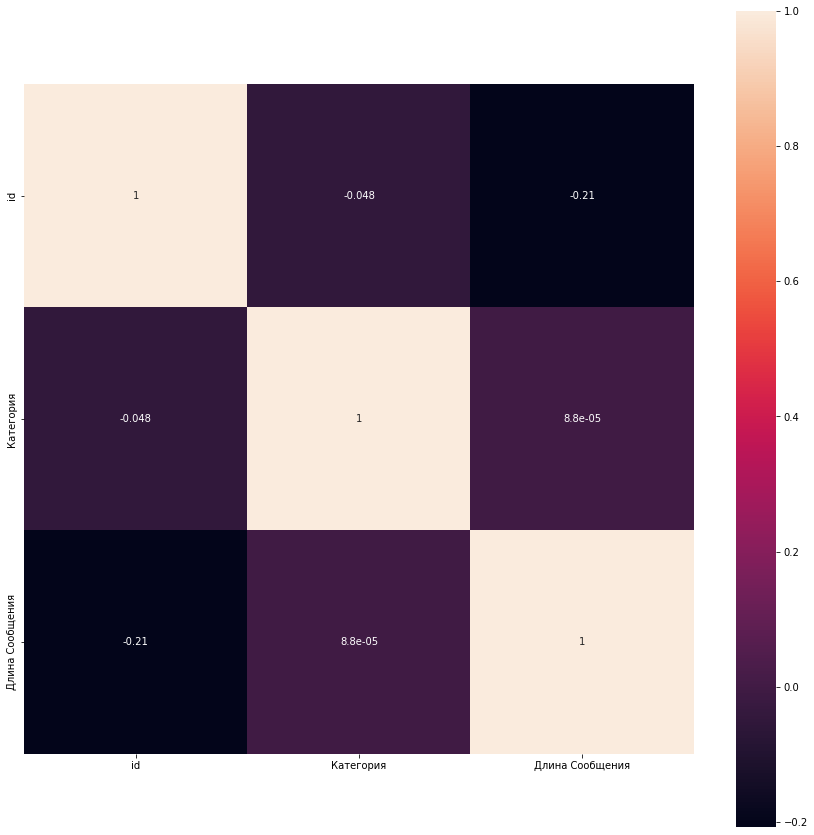

In [138]:
plt.rcParams['figure.figsize']=(15,15)

corr = df_train.corr()
g = sns.heatmap(corr, square = True, annot=True)

## Связь тематики и категории

In [168]:
t = df_train.groupby(["Тематика", "Категория"])["id"].count().reset_index()
t['id'] = np.ones(t.shape[0])
cat_topic_links = t.pivot(columns = "Категория", index="Тематика", values="id").fillna(0)

In [169]:
t.to_excel("cat_topic.xlsx")
# каждая тема отнесена к одной из категорий
(cat_topic_links.sum(axis=1)>1).mean()

0.0

In [170]:
cat_topic_links.to_excel("cat_topic_links.xlsx")
cat_topic_links

Категория,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Тематика,,,,,,,,,,,,,,,,,
«Замороженная» стройка,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Аварийное жильё,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Аварийные деревья,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Безнадзорные животные,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Безопасная дорога в школу на дорогах в границах городских округов и сельских поселений,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Тарификация ж/д перевозок,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Тестовая категория,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Я хочу задать вопрос о вакцинации,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Связь не прослеживается

## Посмотрим в каком виде текст сообщения и нужно ли его приводить в порядок

In [171]:
df_train["Текст Сообщения"][10]

'Здравствуйте, в д. Старый Бузец уже 3 дня не чистят дороги от снега. Нет возможности выехать на работу. Работаю в такси, аренду автомобиля необходимо платить, а я выехать второй день не могу. Стою вот посреди дороги, застряв в снегу, под которым лёд.'

In [172]:
train.iloc[10]

id                                                                 1900
Текст Сообщения       Здравствуйте, в д. Старый Бузец уже 3 дня не ч...
Тематика                                                            138
Ответственное лицо                                                    4
Категория                                                             0
Длина Сообщения                                                     250
text                  Здравствуйте, в д. Старый Бузец уже 3 дня не ч...
text_processed        здравствуйте в д старый бузец уже дня не чистя...
text_stemmed          здравств стар бузец дня чист дорог снег возмож...
text_lemmed           здравствуйте старый бузец день чистить дорога ...
Name: 10, dtype: object

## Предобработка текстов
### Убираем HTML

In [173]:
# Функции для обработки текста

RU_LETTERS = re.compile('[а-яё]+')
CLEAN_HTML = re.compile('<.*?>')
spell = Speller('ru')
morph = MorphAnalyzer()

# Удяляем html-теги
# Удаляем слова короче 3-х символов 
def format_text(raw_text: str) -> str:
    # Убираем html-теги
    txt = re.sub(CLEAN_HTML, '', raw_text)
    
    # Приводим к нижнему регистру
    txt = txt.lower()
    
    # Оставляем только слова из русских букв
    txt = " ".join(RU_LETTERS.findall(txt))
    
    # Удаляем неинформативные слова длиной менее 2-х букв.
    words_filtered = []
    for word in txt.split():
        if len(word) > 2:
            words_filtered.append(word)
    return ' '.join(words_filtered)


# Приводим все слова к нормальной форме
def format_norm(txt: str) -> str:
    words = []
    for word in txt.split():
        m = morph.parse(word)[0]
        if m.tag.POS not in ('PREP', 'CONJ', 'PRCL', 'INTJ'):
            words.append(m.normal_form)
    return ' '.join(words)

In [176]:
# Подготовка данных для заданного датасета.

def format_df_inplace(df_train: pd.DataFrame) -> None:
    # "Причёсываем" Текст Сообщения.
    df_train['Текст Сообщения'] = df_train['Текст Сообщения'].apply(format_text)
    # Исправляем опечатки.
    df_train['Текст Сообщения'] = df_train['Текст Сообщения'].apply(spell)
    # Приводим к нормальной форме
    df_train['Текст Сообщения'] = df_train['Текст Сообщения'].apply(format_norm)
    
    # Тематику преобразовываем в набор токенов.
    df_train['Тематика'] = df_train['Тематика'].apply(format_text)
    # Нормализованные слова помещаем в отдельное поле, так как исходная Тематика нам пригодится
    df_train['Тематика Норм'] = df_train['Тематика'].apply(format_norm)
    
    # Ответственное лицо разбиваем на типы: Администрация, Комиссия, Другое
    df_train['Тип ответственного'] = df_train['Ответственное лицо'].apply(lambda x: 'Администрация' if x[:13] == 'Администрация' 
                                                             else 'Комитет' if x[:7] == 'Комитет' else 'Другое')

In [217]:
import re
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
SPACER = re.compile('\s+')

def cleanhtml(raw_html):
  cleantext = re.sub(CLEANR, ' ', raw_html)
  cleantext = re.sub(SPACER, ' ', cleantext)
  return cleantext
df_train["Текст Сообщения"].apply(cleanhtml)
df_train["Тематика"].apply(cleanhtml)

0       Нарушения, связанные с содержанием электросети...
1                                       Аварийные деревья
2                                   Безнадзорные животные
3       Нескошенная сорная растительность в местах общ...
4                                       Аварийные деревья
                              ...                        
1995                                    Неприятные запахи
1996    Парковки на дорогах в границах городских округ...
1997                                    Аварийные деревья
1998    Нарушение дорожного покрытия (ямы) на дорогах ...
1999                           ПЦР-тест, тест на антитела
Name: Тематика, Length: 2000, dtype: object

In [218]:
df_train["Текст Сообщения"] = df_train["Текст Сообщения"].apply(cleanhtml)
df_train['Тематика Норм'] = df_train['Тематика'].apply(format_norm)

In [219]:
df_train.head()

,id,Текст Сообщения,Тематика,Ответственное лицо,Категория,Тип ответственного,Длина Сообщения,text_stemmed,text_lemmed,Тематика Норм
0,2246,Помогите начальник Льговского рэс не реагирует...,"Нарушения, связанные с содержанием электросети...",Администрация Льговского района,3,Администрация,210,"помог начальник льговск рэс реагир жалоб , мал...",помочь начальник льговский рэс реагировать жал...,"нарушения, связанный содержание электросеть ка..."
1,380,По фасаду дома по адресу ул. Урицкого 22 прох...,Аварийные деревья,Администрация города Курска,3,Администрация,650,по фасад дом адрес ул . урицк 22 проход труб г...,по фасад дом адрес ул . урицкий 22 проходить т...,аварийный дерево
2,2240,Агресивные собаки. На радуге там стая из подро...,Безнадзорные животные,Администрация города Курска,1,Администрация,189,агресивн собак . на радуг ста подросш щенк звр...,агресивный собака . на радуга стая подрасти ще...,безнадзорный животное
3,596,На пересечении улиц Сосновская и Береговая за...,Нескошенная сорная растительность в местах общ...,Комитет дорожного хозяйства города Курска,3,Комитет,302,на пересечен улиц сосновск берегов завал песк ...,на пересечение улица сосновский береговой зава...,нескошенный сорный растительность место общий ...
4,1797,Здравствуйте! Рядом с домом 1 «А» по улице Св...,Аварийные деревья,Комитет городского хозяйства города Курска,3,Комитет,666,"здравств ! ряд дом 1 а улиц светл , вне придом...","здравствуйте ! рядом дом 1 а улица светлый , в...",аварийный дерево


## Steamming

In [178]:
# NLTK - библиотек Python для решения задач обработки естественного языка
import nltk

from nltk.stem.snowball import SnowballStemmer    
from nltk.corpus import stopwords                
from nltk import word_tokenize                   

nltk.download('stopwords')                       
nltk.download('punkt')                           
stemmer = SnowballStemmer("russian")             

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [179]:
russian_stopwords = stopwords.words("russian")    # Список стоп-слов для русского языка

russian_stopwords.extend(['…', '«', '»', '...', 'т.д.', 'т', 'д', 'nan'])

In [184]:
# Провердим стемминг и избавляемся от стоп-слов
from tqdm.auto import tqdm, trange
stemmed_text_column = []
for text in tqdm(df_train['Текст Сообщения']):
    tokens = word_tokenize(text)    
    stemmed_tokens = [stemmer.stem(token) for token in tokens if token not in russian_stopwords]
    text = " ".join(stemmed_tokens)
    stemmed_text_column.append(text)

# Создаем новую колонку в наборе данных
df_train['text_stemmed'] = stemmed_text_column
df_train['text_stemmed'][0]

  0%|          | 0/2000 [00:00<?, ?it/s]

'помог начальник льговск рэс реагир жалоб , мал ветер сид свет , имен деревн больш угон улиц стар слобод . пожалуйст помог , пуска вычист фотоотчет сдела'

In [186]:
df_train.head()

,id,Текст Сообщения,Тематика,Ответственное лицо,Категория,Тип ответственного,Длина Сообщения,text_stemmed
0,2246,Помогите начальник Льговского рэс не реагирует...,"Нарушения, связанные с содержанием электросети...",Администрация Льговского района,3,Администрация,210,"помог начальник льговск рэс реагир жалоб , мал..."
1,380,По фасаду дома по адресу ул. Урицкого 22 прох...,Аварийные деревья,Администрация города Курска,3,Администрация,650,по фасад дом адрес ул . урицк 22 проход труб г...
2,2240,Агресивные собаки. На радуге там стая из подро...,Безнадзорные животные,Администрация города Курска,1,Администрация,189,агресивн собак . на радуг ста подросш щенк звр...
3,596,На пересечении улиц Сосновская и Береговая за...,Нескошенная сорная растительность в местах общ...,Комитет дорожного хозяйства города Курска,3,Комитет,302,на пересечен улиц сосновск берегов завал песк ...
4,1797,Здравствуйте! Рядом с домом 1 «А» по улице Св...,Аварийные деревья,Комитет городского хозяйства города Курска,3,Комитет,666,"здравств ! ряд дом 1 а улиц светл , вне придом..."


## Лемматизация

In [187]:
!pip install pymorphy2           
!pip install pymorphy2-dicts     
!pip install DAWG-Python          


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [188]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [189]:
morph.parse('шел')[0].normal_form  # Получение нулевой формы слова

'идти'

In [190]:
# Провердим лемматизацию и избавляемся от стоп-слов
lemm_texts_column = []
for text in tqdm(df_train['Текст Сообщения']):
    tokens = word_tokenize(text)    
    lemmed_tokens = [morph.parse(token)[0].normal_form for token in tokens if token not in russian_stopwords]
    text = " ".join(lemmed_tokens)
    lemm_texts_column.append(text)
    
# Создаем новую колонку в наборе данных
df_train['text_lemmed'] = lemm_texts_column

df_train['text_lemmed'][0]

  0%|          | 0/2000 [00:00<?, ?it/s]

'помочь начальник льговский рэс реагировать жалоба , малый ветер сидеть свет , именно деревня больший угон улица старый слобода . пожалуйста помочь , пускай вычистить фотоотчёт сделать'

In [191]:
df_train.head()

,id,Текст Сообщения,Тематика,Ответственное лицо,Категория,Тип ответственного,Длина Сообщения,text_stemmed,text_lemmed
0,2246,Помогите начальник Льговского рэс не реагирует...,"Нарушения, связанные с содержанием электросети...",Администрация Льговского района,3,Администрация,210,"помог начальник льговск рэс реагир жалоб , мал...",помочь начальник льговский рэс реагировать жал...
1,380,По фасаду дома по адресу ул. Урицкого 22 прох...,Аварийные деревья,Администрация города Курска,3,Администрация,650,по фасад дом адрес ул . урицк 22 проход труб г...,по фасад дом адрес ул . урицкий 22 проходить т...
2,2240,Агресивные собаки. На радуге там стая из подро...,Безнадзорные животные,Администрация города Курска,1,Администрация,189,агресивн собак . на радуг ста подросш щенк звр...,агресивный собака . на радуга стая подрасти ще...
3,596,На пересечении улиц Сосновская и Береговая за...,Нескошенная сорная растительность в местах общ...,Комитет дорожного хозяйства города Курска,3,Комитет,302,на пересечен улиц сосновск берегов завал песк ...,на пересечение улица сосновский береговой зава...
4,1797,Здравствуйте! Рядом с домом 1 «А» по улице Св...,Аварийные деревья,Комитет городского хозяйства города Курска,3,Комитет,666,"здравств ! ряд дом 1 а улиц светл , вне придом...","здравствуйте ! рядом дом 1 а улица светлый , в..."


## Токенизация

In [192]:
# from nltk import word_tokenize

word_tokenize(df_train['text_lemmed'][0])

['помочь',
 'начальник',
 'льговский',
 'рэс',
 'реагировать',
 'жалоба',
 ',',
 'малый',
 'ветер',
 'сидеть',
 'свет',
 ',',
 'именно',
 'деревня',
 'больший',
 'угон',
 'улица',
 'старый',
 'слобода',
 '.',
 'пожалуйста',
 'помочь',
 ',',
 'пускай',
 'вычистить',
 'фотоотчёт',
 'сделать']

## Мешок слов

In [193]:
# CountVectorizer - класс конвертации текста в матрицу токенов
from sklearn.feature_extraction.text import CountVectorizer

In [194]:
# Создание матрицы признаков на основе мешка слов
count = CountVectorizer()
bag_of_words = count.fit_transform(df_train['text_lemmed'])
bag_of_words.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [195]:
count.get_feature_names_out()

array(['00', '000', '0000', ..., 'ёж', 'ёлка', 'ёлочка'], dtype=object)

In [196]:
# Создание матрицы признаков для 2-грамм
count_2gram = CountVectorizer(ngram_range=(2,2))
bag_of_2grams = count_2gram.fit_transform(df_train['text_lemmed'])
bag_of_2grams.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [197]:
count_2gram.get_feature_names_out()  # Вывод имен признаков

array(['00 00', '00 06', '00 08', ..., 'ёлка новый', 'ёлка озеленить',
       'ёлочка надеяться'], dtype=object)

## TF-IDF

In [198]:
# TfidfVectorizer - класс для преобразования текста в частотные векторы слов
from sklearn.feature_extraction.text import TfidfVectorizer

In [199]:
# Создание матрицы признаков
from sklearn.feature_extraction.text import TfidfVectorizer
td = TfidfVectorizer(max_features = 4500)
#X = td.fit_transform(X).toarray()

## Классификация сравнением тематики прямым подсчетом совпадающих слов

---



In [206]:
# Строим словарь соответствий Тематика - Категория для заданного датасета

def create_theme_cat_map(df: pd.DataFrame) -> Dict:
    theme_cat = dict()
    for index, row in df.iterrows():
        if row['Тематика'] not in theme_cat:
            theme_cat[row['Тематика']] = row['Категория']
    return theme_cat

In [207]:
# Строим словарь соответствий "Множество слов из поля fld_name - Категория" для заданного датасета.

def create_theme_set_cat_map(df: pd.DataFrame, fld_name: str) -> Dict:
    theme_cat = dict()
    for index, row in df.iterrows():
        if row[fld_name] not in theme_cat:
            # theme_cat[frozenset(filter(lambda x: len(x) > 2, row['Тематика'].split()))] = row['Категория']
            theme_cat[frozenset(row[fld_name].split())] = row['Категория']
    return theme_cat

In [209]:
# Подбор категории на основе прямого сравнения множества слов в поле fld_name

def predict_simplest(df_train_data: pd.DataFrame, df_test_data: pd.DataFrame, fld_name: str) -> List[int]:
    theme_set_cat_map = create_theme_set_cat_map(df_train_data, fld_name)
    res_cat = []
    for index, row in df_test_data.iterrows():
        # theme_set = set(filter(lambda x: len(x) > 2, row['Тематика'].split()))
        theme_set = set(row[fld_name].split())
        cur_d = 0
        cur_cat = None
        for key in theme_set_cat_map:
            d = len(key.intersection(theme_set))
            if d > cur_d:
                cur_d = d
                cur_cat = theme_set_cat_map[key]
                # print(key.intersection(theme_set))
        # res_cat.append(cur_cat)
        if cur_d > 0 and ((cur_d <= 3 and len(theme_set) <= 7) or cur_d > 3):
        # if (cur_d == len(theme_set)) or cur_d > 3:
            res_cat.append(cur_cat)
        else:
            res_cat.append(None)
    return res_cat

In [213]:
# Проверка на кроссвалидации варианта с простейшим классификатором. Оценка количества неверно определившихся и не определившихся категорий.

def check_cv_simplest(fld_name: str):
    res_none = []
    res_correct = []
    res_incorrect = []
    for ind in range(50):
        df_train_oper, df_test_oper, train_oper_y, test_oper_y = train_test_split(df_train,
                                                                                  df_train['Категория'], 
                                                                                  test_size=0.3,
                                                                                  random_state=ind * 10)
        predict_y = np.array(predict_simplest(df_train_oper, df_test_oper, fld_name))
        res_none.append(np.sum(predict_y == None))
        res_correct.append(sum((predict_y == test_oper_y)[predict_y != None]))
        res_incorrect.append(sum((predict_y != test_oper_y)[predict_y != None]))
    return dict(res_none=res_none, res_correct=res_correct, res_incorrect=res_incorrect)

def print_stat_check_cv_simplest(r: Dict) -> None:
    print(f"Статистика None. max: {max(r['res_none'])}, min: {min(r['res_none'])}, mean: {np.mean(r['res_none'])}, median: {np.median(r['res_none'])}, sd: {np.std(r['res_none'])}")
    print(f"Неверных ответов. max: {max(r['res_incorrect'])}, min: {min(r['res_incorrect'])}, mean: {np.mean(r['res_incorrect'])}, median: {np.median(r['res_incorrect'])}, sd: {np.std(r['res_incorrect'])}")
    print(f"Верных ответов. max: {max(r['res_correct'])}, min: {min(r['res_correct'])}, mean: {np.mean(r['res_correct'])}, median: {np.median(r['res_correct'])}, sd: {np.std(r['res_correct'])}")

In [214]:
r = check_cv_simplest('Тематика')

In [215]:
print_stat_check_cv_simplest(r)

Статистика None. max: 9, min: 0, mean: 1.8, median: 1.0, sd: 1.9390719429665315
Неверных ответов. max: 7, min: 0, mean: 3.22, median: 3.0, sd: 1.6886681142249356
Верных ответов. max: 599, min: 586, mean: 594.98, median: 595.0, sd: 2.6943644890771554


In [220]:
r_norm = check_cv_simplest('Тематика Норм')
print_stat_check_cv_simplest(r_norm)

Статистика None. max: 6, min: 0, mean: 0.98, median: 1.0, sd: 1.3189389675038037
Неверных ответов. max: 10, min: 0, mean: 3.42, median: 3.0, sd: 2.209886874932742
Верных ответов. max: 599, min: 584, mean: 595.6, median: 596.0, sd: 2.80713376952364


Нормализация тематики не повлияло на результат

## Наивный Байес

---



In [222]:
class NaiveBayes:
    def __init__(self, train_text_list: List[str], train_resp_type: List[str], train_cat_list: List[int]):
        if not (len(train_text_list) == len(train_cat_list) == len(train_resp_type)):
            raise Exception('Не совпадает длина входных списков')
            
        self.train_cnt = len(train_text_list)
        
        # Сколько раз встречается каждое слово во всех категориях
        # Сколько раз встречается каждое слово в каждой категории
        # Сколько раз встречается Тип ответственного лица в каждой категории
        # Количество записей с каждой категорией

        self.word_cnt = defaultdict(int)
        self.word_cnt_by_cat = defaultdict(int)
        self.train_cnt_by_cat = defaultdict(int)
        self.resp_type_cnt_by_cat = defaultdict(int)
        for ind in range(len(train_text_list)):
            txt = train_text_list[ind]
            cat = train_cat_list[ind]
            for word in set(txt.split()):
                self.word_cnt[word] += 1
                self.word_cnt_by_cat[(cat, word)] += 1
            self.resp_type_cnt_by_cat[(cat, train_resp_type[ind])] += 1
            self.train_cnt_by_cat[cat] += 1
        
        
    def get_word_cnt_in_cat(self, cat: int, word: str) -> int:
        return self.word_cnt_by_cat.get((cat, word)) or 1

    def get_word_cnt_not_in_cat(self, cat: int, word: str) -> int:
        return (self.train_cnt_by_cat[cat] - self.word_cnt_by_cat.get((cat, word), 0)) or 1
    
    def get_resp_type_cnt_in_cat(self, cat: int, resp_type: str) -> int:
        return self.resp_type_cnt_by_cat.get((cat, resp_type), 0)
        # return self.resp_type_cnt_by_cat.get((cat, resp_type)) or 1
        
    def get_cat_probs(self, txt: str, resp_type: str) -> List[float]:
        chance = [0] * 17
        word_set = set(txt.split())
        for cat in range(17):
            # Если категория встречается редко, то оценки будут содержать погрешности
            # Подбираем порог, ниже которого метод работать не будет. 
            
            if self.train_cnt_by_cat[cat] < 30:
                chance[cat] = 0
            else:
                chance[cat] = self.train_cnt_by_cat[cat] / self.train_cnt
                for word in self.word_cnt:
                    chance[cat] *= (self.get_word_cnt_in_cat(cat, word) 
                                   if word in word_set else self.get_word_cnt_not_in_cat(cat, word)) / self.train_cnt_by_cat[cat]
                chance[cat] *= self.get_resp_type_cnt_in_cat(cat, resp_type) / self.train_cnt_by_cat[cat]
        sum_chance = sum(chance)
        return [ch / sum_chance for ch in chance], chance

In [223]:
# Разбиваем тренировочный датасет на две части
df_train_oper, df_test_oper, train_oper_y, test_oper_y = train_test_split(df_train, df_train['Категория'], test_size=0.3, random_state=42)

In [224]:
# Выполняем классификацию, на данныех поля Текст Сообщения

bayes = NaiveBayes(df_train_oper['Текст Сообщения'].values, 
                   df_train_oper['Тип ответственного'].values,
                   df_train_oper['Категория'].values)
b_pred_y = [np.argmax(bayes.get_cat_probs(txt, resp_type)) for txt, resp_type in zip(df_test_oper['Текст Сообщения'].values, 
                                                                          df_test_oper['Тип ответственного'].values)]

In [226]:
sum(test_oper_y != b_pred_y), sum(test_oper_y == b_pred_y)

(513, 87)

In [227]:
# Выполняем классификацию, опираясь на данные поля Тематика Норм

bayes = NaiveBayes(df_train_oper['Тематика Норм'].values, 
                   df_train_oper['Тип ответственного'].values,
                   df_train_oper['Категория'].values)

b_pred_y = [np.argmax(bayes.get_cat_probs(txt, resp_type)) for txt, resp_type in zip(df_test_oper['Тематика Норм'].values, 
                                                                                     df_test_oper['Тип ответственного'].values)]

In [228]:
sum(test_oper_y != b_pred_y), sum(test_oper_y == b_pred_y)

(49, 551)

In [229]:
# Проверка на кроссвалидации варианта с наивным Байесом. Оценка количества верно и неверно определившихся.

def check_cv_bayes(fld_name: str) -> Dict:
    res_correct = []
    res_incorrect = []
    for ind in range(50):
        df_train_oper, df_test_oper, train_oper_y, test_oper_y = train_test_split(df_train,
                                                                                  df_train['Категория'], 
                                                                                  test_size=0.3,
                                                                                  random_state=ind * 10)

        bayes = NaiveBayes(df_train_oper[fld_name].values, 
                           df_train_oper['Тип ответственного'].values, 
                           df_train_oper['Категория'].values)
        b_pred_y = [np.argmax(bayes.get_cat_probs(txt, resp_type)) for txt, resp_type in zip(df_test_oper[fld_name],
                                                                                             df_test_oper['Тип ответственного'])]

        res_correct.append(sum((b_pred_y == test_oper_y)))
        res_incorrect.append(sum((b_pred_y != test_oper_y)))
    return dict(res_correct=res_correct, res_incorrect=res_incorrect)

def print_stat_check_cv_bayes(r: Dict) -> None:
    print(f"Статистика неверных ответов. max: {max(r['res_incorrect'])}, min: {min(r['res_incorrect'])}, mean: {np.mean(r['res_incorrect'])}, median: {np.median(r['res_incorrect'])}, sd: {np.std(r['res_incorrect'])}")
    print(f"Статистика верных ответов. max: {max(r['res_correct'])}, min: {min(r['res_correct'])}, mean: {np.mean(r['res_correct'])}, median: {np.median(r['res_correct'])}, sd: {np.std(r['res_correct'])}")

In [230]:
# Опираясь на данные поля Тематика

r_cv_b = check_cv_bayes('Тематика')
print_stat_check_cv_bayes(r_cv_b)

Статистика неверных ответов. max: 78, min: 42, mean: 54.56, median: 54.0, sd: 7.288785907131585
Статистика верных ответов. max: 558, min: 522, mean: 545.44, median: 546.0, sd: 7.288785907131586


In [231]:
# Опираясь на данные поля Тематика Норм

r_cv_b_norm = check_cv_bayes('Тематика Норм')
print_stat_check_cv_bayes(r_cv_b_norm)

Статистика неверных ответов. max: 75, min: 39, mean: 49.88, median: 49.0, sd: 6.912712926196197
Статистика верных ответов. max: 561, min: 525, mean: 550.12, median: 551.0, sd: 6.912712926196197


## Комбинируем подходы

---



In [234]:
def predict_comb(df_train_data: pd.DataFrame, df_test_data: pd.DataFrame, print_none_ind=False) -> List[int]:
    predict_y = predict_simplest(df_train_data, df_test_data, 'Тематика')    
    
    bayes = NaiveBayes(df_train_data['Тематика Норм'].values, 
                   df_train_data['Тип ответственного'].values,
                   df_train_data['Категория'].values)
    
    for ind in range(len(predict_y)):
        if predict_y[ind] is None:
            if print_none_ind:
                print(ind)
            predict_y[ind] = np.argmax(bayes.get_cat_probs(df_test_data['Тематика Норм'].values[ind], 
                                                           df_test_data['Тип ответственного'].values[ind]))
    return predict_y

In [235]:
def check_cv_comb() -> Dict:
    res_correct = []
    res_incorrect = []
    for ind in range(50):
        df_train_oper, df_test_oper, train_oper_y, test_oper_y = train_test_split(df_train,
                                                                                  df_train['Категория'], 
                                                                                  test_size=0.3,
                                                                                  random_state=ind * 10)

        b_pred_y = predict_comb(df_train_oper, df_test_oper)
        res_correct.append(sum((b_pred_y == test_oper_y)))
        res_incorrect.append(sum((b_pred_y != test_oper_y)))
    return dict(res_correct=res_correct, res_incorrect=res_incorrect)

def print_stat_check_cv_comb(r: Dict) -> None:
    print(f"Статистика неверных ответов. max: {max(r['res_incorrect'])}, min: {min(r['res_incorrect'])}, mean: {np.mean(r['res_incorrect'])}, median: {np.median(r['res_incorrect'])}, sd: {np.std(r['res_incorrect'])}")
    print(f"Статистика верных ответов. max: {max(r['res_correct'])}, min: {min(r['res_correct'])}, mean: {np.mean(r['res_correct'])}, median: {np.median(r['res_correct'])}, sd: {np.std(r['res_correct'])}")

In [236]:
r_comb = check_cv_comb()

In [237]:
print_stat_check_cv_comb(r_comb)

Статистика неверных ответов. max: 14, min: 1, mean: 4.5, median: 4.0, sd: 2.3937418407171647
Статистика верных ответов. max: 599, min: 586, mean: 595.5, median: 596.0, sd: 2.3937418407171647


## Строим прогноз для тестового датасета.

---



In [241]:
df_test.head(10)


,id,Текст Сообщения,Тематика,Ответственное лицо
0,843,<p>Здравствуйте. На улице Мира &nbsp;было заме...,Неработающее наружное освещение,Администрация Курчатовского района
1,1422,<p>Уже вторую неделю не горит уличное освещени...,Неработающее наружное освещение,Комитет жилищно-коммунального хозяйства города...
2,2782,Не работает освещение во дворе дома 11а по Эне...,Неработающее наружное освещение,Комитет жилищно-коммунального хозяйства города...
3,2704,После покоса сорной растительности на газоне м...,Неудовлетворительная уборка улиц и тротуаров,Администрация Центрального округа города Курска
4,1,<p>Прошу принять меры к водителю маршрута 263:...,Неудовлетворительный внешний вид (поведение) в...,Администрация города Курска
5,68,<p>Добрый день!</p><p>Просим Вас создать остан...,Необходимо назначение дополнительных поездов,Администрация Льговского района
6,2408,Мусор га контейнерной площадке,Не соответствующий установленным нормам сбор и...,Комитет жилищно-коммунального хозяйства города...
7,1587,<p>Добрый день! Шестой день отсутствует отопле...,Нарушение теплоснабжения многоквартирного дома,ООО `УК Курский завод КПД им. А.Ф. Дериглазова`
8,1504,<p>Нарушения в сфере ЖКХ</p>,Нарушения в вопросах оплаты услуг ЖКХ,Государственная жилищная инспекция Курской обл...
9,880,"<p>Моему отцу, Булыгину Валерию Васильевичу бы...",Неудовлетворительное материально-техническое с...,Комитет здравоохранения Курской области


## Проведем обработку данных тестового датасета

---



## Убираем HTML
---



In [242]:
RU_LETTERS = re.compile('[а-яё]+')
CLEAN_HTML = re.compile('<.*?>')
spell = Speller('ru')
morph = MorphAnalyzer()

# Удяляем html-теги
# Удаляем слова короче 3-х символов 
def format_text(raw_text: str) -> str:
    # Убираем html-теги
    txt = re.sub(CLEAN_HTML, '', raw_text)
    
    # Приводим к нижнему регистру
    txt = txt.lower()
    
    # Оставляем только слова из русских букв
    txt = " ".join(RU_LETTERS.findall(txt))
    
    # Удаляем неинформативные слова длиной менее 2-х букв.
    words_filtered = []
    for word in txt.split():
        if len(word) > 2:
            words_filtered.append(word)
    return ' '.join(words_filtered)


# Приводим все слова к нормальной форме
def format_norm(txt: str) -> str:
    words = []
    for word in txt.split():
        m = morph.parse(word)[0]
        if m.tag.POS not in ('PREP', 'CONJ', 'PRCL', 'INTJ'):
            words.append(m.normal_form)
    return ' '.join(words)

In [243]:
# Подготовка данных для заданного датасета.

def format_df_inplace(df_test: pd.DataFrame) -> None:
    # "Причёсываем" Текст Сообщения.
    df_test['Текст Сообщения'] = df_test['Текст Сообщения'].apply(format_text)
    # Исправляем опечатки.
    df_test['Текст Сообщения'] = df_test['Текст Сообщения'].apply(spell)
    # Приводим к нормальной форме
    df_test['Текст Сообщения'] = df_test['Текст Сообщения'].apply(format_norm)
    
    # Тематику преобразовываем в набор токенов.
    df_test['Тематика'] = df_test['Тематика'].apply(format_text)
    # Нормализованные слова помещаем в отдельное поле, так как исходная Тематика нам пригодится
    df_test['Тематика Норм'] = df_test['Тематика'].apply(format_norm)

In [244]:
import re
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
SPACER = re.compile('\s+')

def cleanhtml(raw_html):
  cleantext = re.sub(CLEANR, ' ', raw_html)
  cleantext = re.sub(SPACER, ' ', cleantext)
  return cleantext
df_test["Текст Сообщения"].apply(cleanhtml)
df_test["Тематика"].apply(cleanhtml)

0                        Неработающее наружное освещение
1                        Неработающее наружное освещение
2                        Неработающее наружное освещение
3           Неудовлетворительная уборка улиц и тротуаров
4      Неудовлетворительный внешний вид (поведение) в...
                             ...                        
995                                    Неприятные запахи
996                                    Аварийные деревья
997    Нарушение дорожного покрытия (ямы) на дорогах ...
998                             Сертификат переболевшего
999    Нарушения порядка предоставления мер социально...
Name: Тематика, Length: 1000, dtype: object

In [247]:
df_test["Текст Сообщения"] = df_train["Текст Сообщения"].apply(cleanhtml)
df_test['Тематика Норм'] = df_train['Тематика'].apply(format_norm)

In [248]:
df_test.head()

,id,Текст Сообщения,Тематика,Ответственное лицо,Тематика Норм
0,843,Помогите начальник Льговского рэс не реагирует...,Неработающее наружное освещение,Администрация Курчатовского района,"нарушения, связанный содержание электросеть ка..."
1,1422,По фасаду дома по адресу ул. Урицкого 22 прох...,Неработающее наружное освещение,Комитет жилищно-коммунального хозяйства города...,аварийный дерево
2,2782,Агресивные собаки. На радуге там стая из подро...,Неработающее наружное освещение,Комитет жилищно-коммунального хозяйства города...,безнадзорный животное
3,2704,На пересечении улиц Сосновская и Береговая за...,Неудовлетворительная уборка улиц и тротуаров,Администрация Центрального округа города Курска,нескошенный сорный растительность место общий ...
4,1,Здравствуйте! Рядом с домом 1 «А» по улице Св...,Неудовлетворительный внешний вид (поведение) в...,Администрация города Курска,аварийный дерево


## Steamming

---



In [249]:
# NLTK - библиотек Python для решения задач обработки естественного языка
import nltk

from nltk.stem.snowball import SnowballStemmer    
from nltk.corpus import stopwords                
from nltk import word_tokenize                   

nltk.download('stopwords')                       
nltk.download('punkt')                           
stemmer = SnowballStemmer("russian")     

russian_stopwords = stopwords.words("russian")    # Список стоп-слов для русского языка

russian_stopwords.extend(['…', '«', '»', '...', 'т.д.', 'т', 'д', 'nan'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [250]:
# Провердим стемминг и избавляемся от стоп-слов
from tqdm.auto import tqdm, trange
stemmed_text_column = []
for text in tqdm(df_test['Текст Сообщения']):
    tokens = word_tokenize(text)    
    stemmed_tokens = [stemmer.stem(token) for token in tokens if token not in russian_stopwords]
    text = " ".join(stemmed_tokens)
    stemmed_text_column.append(text)

# Создаем новую колонку в наборе данных
df_test['text_stemmed'] = stemmed_text_column
df_test['text_stemmed'][0]

  0%|          | 0/1000 [00:00<?, ?it/s]

'помог начальник льговск рэс реагир жалоб , мал ветер сид свет , имен деревн больш угон улиц стар слобод . пожалуйст помог , пуска вычист фотоотчет сдела'

In [251]:
df_test.head()

,id,Текст Сообщения,Тематика,Ответственное лицо,Тематика Норм,text_stemmed
0,843,Помогите начальник Льговского рэс не реагирует...,Неработающее наружное освещение,Администрация Курчатовского района,"нарушения, связанный содержание электросеть ка...","помог начальник льговск рэс реагир жалоб , мал..."
1,1422,По фасаду дома по адресу ул. Урицкого 22 прох...,Неработающее наружное освещение,Комитет жилищно-коммунального хозяйства города...,аварийный дерево,по фасад дом адрес ул . урицк 22 проход труб г...
2,2782,Агресивные собаки. На радуге там стая из подро...,Неработающее наружное освещение,Комитет жилищно-коммунального хозяйства города...,безнадзорный животное,агресивн собак . на радуг ста подросш щенк звр...
3,2704,На пересечении улиц Сосновская и Береговая за...,Неудовлетворительная уборка улиц и тротуаров,Администрация Центрального округа города Курска,нескошенный сорный растительность место общий ...,на пересечен улиц сосновск берегов завал песк ...
4,1,Здравствуйте! Рядом с домом 1 «А» по улице Св...,Неудовлетворительный внешний вид (поведение) в...,Администрация города Курска,аварийный дерево,"здравств ! ряд дом 1 а улиц светл , вне придом..."


## Лемматизация

---



In [252]:
!pip install pymorphy2           
!pip install pymorphy2-dicts     
!pip install DAWG-Python  


import pymorphy2
morph = pymorphy2.MorphAnalyzer()


morph.parse('шел')[0].normal_form  # Получение нулевой формы слова



# Провердим лемматизацию и избавляемся от стоп-слов
lemm_texts_column = []
for text in tqdm(df_test['Текст Сообщения']):
    tokens = word_tokenize(text)    
    lemmed_tokens = [morph.parse(token)[0].normal_form for token in tokens if token not in russian_stopwords]
    text = " ".join(lemmed_tokens)
    lemm_texts_column.append(text)
    
# Создаем новую колонку в наборе данных
df_test['text_lemmed'] = lemm_texts_column

df_test['text_lemmed'][0]


df_test.head()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


  0%|          | 0/1000 [00:00<?, ?it/s]

,id,Текст Сообщения,Тематика,Ответственное лицо,Тематика Норм,text_stemmed,text_lemmed
0,843,Помогите начальник Льговского рэс не реагирует...,Неработающее наружное освещение,Администрация Курчатовского района,"нарушения, связанный содержание электросеть ка...","помог начальник льговск рэс реагир жалоб , мал...",помочь начальник льговский рэс реагировать жал...
1,1422,По фасаду дома по адресу ул. Урицкого 22 прох...,Неработающее наружное освещение,Комитет жилищно-коммунального хозяйства города...,аварийный дерево,по фасад дом адрес ул . урицк 22 проход труб г...,по фасад дом адрес ул . урицкий 22 проходить т...
2,2782,Агресивные собаки. На радуге там стая из подро...,Неработающее наружное освещение,Комитет жилищно-коммунального хозяйства города...,безнадзорный животное,агресивн собак . на радуг ста подросш щенк звр...,агресивный собака . на радуга стая подрасти ще...
3,2704,На пересечении улиц Сосновская и Береговая за...,Неудовлетворительная уборка улиц и тротуаров,Администрация Центрального округа города Курска,нескошенный сорный растительность место общий ...,на пересечен улиц сосновск берегов завал песк ...,на пересечение улица сосновский береговой зава...
4,1,Здравствуйте! Рядом с домом 1 «А» по улице Св...,Неудовлетворительный внешний вид (поведение) в...,Администрация города Курска,аварийный дерево,"здравств ! ряд дом 1 а улиц светл , вне придом...","здравствуйте ! рядом дом 1 а улица светлый , в..."


## Токенизация

---




In [253]:
# from nltk import word_tokenize

word_tokenize(df_test['text_lemmed'][0])


['помочь',
 'начальник',
 'льговский',
 'рэс',
 'реагировать',
 'жалоба',
 ',',
 'малый',
 'ветер',
 'сидеть',
 'свет',
 ',',
 'именно',
 'деревня',
 'больший',
 'угон',
 'улица',
 'старый',
 'слобода',
 '.',
 'пожалуйста',
 'помочь',
 ',',
 'пускай',
 'вычистить',
 'фотоотчёт',
 'сделать']

## Мешок слов

---



In [255]:
# CountVectorizer - класс конвертации текста в матрицу токенов
from sklearn.feature_extraction.text import CountVectorizer

# Создание матрицы признаков на основе мешка слов
count = CountVectorizer()
bag_of_words = count.fit_transform(df_test['text_lemmed'])
bag_of_words.toarray()

count.get_feature_names_out()

# Создание матрицы признаков для 2-грамм
count_2gram = CountVectorizer(ngram_range=(2,2))
bag_of_2grams = count_2gram.fit_transform(df_test['text_lemmed'])
bag_of_2grams.toarray()

count_2gram.get_feature_names_out()  # Вывод имен признаков

array(['00 00', '00 06', '00 10', ..., 'ящик просить', 'ёлка новый',
       'ёлка озеленить'], dtype=object)

## Добавим колонку с типом ответственного лица

---



In [257]:
df_test['Тип ответственного'] = df_test['Ответственное лицо'].apply(lambda x: 'Администрация' if x[:13] == 'Администрация'                                                                      else 'Комитет' if x[:7] == 'Комитет' else 'Другое')
pd.crosstab(df_test['Тип ответственного'], df_train['Категория'])


Категория,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Тип ответственного,,,,,,,,,,,,,,,,,
Администрация,110,7,1,204,15,0,1,4,23,1,6,4,0,0,1,1,27
Другое,32,3,0,56,12,2,0,3,10,1,2,1,0,0,0,1,12
Комитет,106,5,0,233,17,2,3,4,38,1,12,4,1,5,2,1,26


In [258]:
df_test.head()

,id,Текст Сообщения,Тематика,Ответственное лицо,Тематика Норм,text_stemmed,text_lemmed,Тип ответственного
0,843,Помогите начальник Льговского рэс не реагирует...,Неработающее наружное освещение,Администрация Курчатовского района,"нарушения, связанный содержание электросеть ка...","помог начальник льговск рэс реагир жалоб , мал...",помочь начальник льговский рэс реагировать жал...,Администрация
1,1422,По фасаду дома по адресу ул. Урицкого 22 прох...,Неработающее наружное освещение,Комитет жилищно-коммунального хозяйства города...,аварийный дерево,по фасад дом адрес ул . урицк 22 проход труб г...,по фасад дом адрес ул . урицкий 22 проходить т...,Комитет
2,2782,Агресивные собаки. На радуге там стая из подро...,Неработающее наружное освещение,Комитет жилищно-коммунального хозяйства города...,безнадзорный животное,агресивн собак . на радуг ста подросш щенк звр...,агресивный собака . на радуга стая подрасти ще...,Комитет
3,2704,На пересечении улиц Сосновская и Береговая за...,Неудовлетворительная уборка улиц и тротуаров,Администрация Центрального округа города Курска,нескошенный сорный растительность место общий ...,на пересечен улиц сосновск берегов завал песк ...,на пересечение улица сосновский береговой зава...,Администрация
4,1,Здравствуйте! Рядом с домом 1 «А» по улице Св...,Неудовлетворительный внешний вид (поведение) в...,Администрация города Курска,аварийный дерево,"здравств ! ряд дом 1 а улиц светл , вне придом...","здравствуйте ! рядом дом 1 а улица светлый , в...",Администрация


In [259]:
df_test['Категория'] = predict_comb(df_train, df_test, True)

238
706


In [262]:
df_final_result = df_test[['id', 'Категория']]
df_final_result.head(20)

,id,Категория
0,843,3
1,1422,3
2,2782,3
3,2704,3
4,1,8
5,68,8
6,2408,3
7,1587,3
8,1504,3
9,880,4


In [261]:
df_final_result.to_csv('/content/final_result.csv', index = False)
rr = predict_comb(df_train, df_test) 

## Проведем обучение классификации используя еще один метод обучения - с помощью инструментов Keras & TensorFlow

---



## Нормализуем датасет для обучения нейронной сети

In [263]:
texts = df_train['Текст Сообщения'].values # Извлекаем данные всех текстов из столбца 'Текст Сообщения'
classes = list(train['Категория'].values) 
maxWordsCount = 9000 

print(df_train['Категория'].unique()) # Выводим все уникальные значения классов
nClasses = df_train['Категория'].nunique() 
print('Количество классов =', nClasses) 

[ 3  1 16  0  6  8  4 13 10 11 14  7  5 15  2  9 12]
Количество классов = 17


In [264]:
#Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью

tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', oov_token='unknown', char_level=False)#False

tokenizer.fit_on_texts(texts) # Даём в обработку наши тексты, методу, который соберет словарь частотности

# Формируем матрицу индексов по принципу Bag of Words
xAll = tokenizer.texts_to_matrix(texts) 
print(xAll.shape)  
print(xAll[0, :20])

(2000, 9000)
[0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [265]:
# Посмотрим размер словаря
print("Размер словаря", len(tokenizer.word_index.items()))

Размер словаря 18374


In [266]:
#Преобразовываем категории в векторы
encoder = LabelEncoder() 
encoder.fit(classes) 
classesEncoded = encoder.transform(classes) 
print('Посмотрим кодированные категории', encoder.classes_) 
print('Количество',classesEncoded.shape)
print('Посмотрим как выглядят первые 17 категорий', classesEncoded[:17])

yAll = utils.to_categorical(classesEncoded, nClasses) 
print('Форма лейблов', yAll.shape) 
print('Первая строка лейблов',yAll[0])

Посмотрим кодированные категории [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Количество (2000,)
Посмотрим как выглядят первые 17 категорий [ 3  3  1  3  3  3  3 16  3  0  0  3  3  3  0  3  3]
Форма лейблов (2000, 17)
Первая строка лейблов [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [267]:
# разбиваем все данные на обучающую и тестовую выборки с помощью метода train_test_split из библиотеки sklearn
xTrain, xVal, yTrain, yVal = train_test_split(xAll, yAll, test_size=0.2, shuffle = True) 
print(xTrain.shape)
print(yTrain.shape) 

(1600, 9000)
(1600, 17)


## Сохранение весов модели для выбора наилучшей эпохи

In [268]:
# Сохраняем сеть на каждой эпохе
# {epoch:02d} - номер эпохи
# {val_acc:.4f} - значение аккуратности на проверочном ноборе данных
callbacks = [ModelCheckpoint('save_models/Appeals_of_citizens-{epoch:02d}-{loss:.4f}.hdf5')]


## Обучаем нейронную сеть

Epoch 1/100
25/25 - 2s - loss: 2.3833 - accuracy: 0.3706 - val_loss: 1.9970 - val_accuracy: 0.4650 - 2s/epoch - 68ms/step
Epoch 2/100
25/25 - 0s - loss: 1.5968 - accuracy: 0.5175 - val_loss: 1.4172 - val_accuracy: 0.5400 - 488ms/epoch - 20ms/step
Epoch 3/100
25/25 - 0s - loss: 1.0865 - accuracy: 0.6413 - val_loss: 1.1584 - val_accuracy: 0.6725 - 375ms/epoch - 15ms/step
Epoch 4/100
25/25 - 0s - loss: 0.7238 - accuracy: 0.7744 - val_loss: 1.0877 - val_accuracy: 0.6950 - 411ms/epoch - 16ms/step
Epoch 5/100
25/25 - 0s - loss: 0.4916 - accuracy: 0.8481 - val_loss: 1.0695 - val_accuracy: 0.7175 - 396ms/epoch - 16ms/step
Epoch 6/100
25/25 - 0s - loss: 0.3421 - accuracy: 0.9038 - val_loss: 1.1251 - val_accuracy: 0.7325 - 437ms/epoch - 17ms/step
Epoch 7/100
25/25 - 0s - loss: 0.2678 - accuracy: 0.9206 - val_loss: 1.1897 - val_accuracy: 0.7450 - 392ms/epoch - 16ms/step
Epoch 8/100
25/25 - 0s - loss: 0.2195 - accuracy: 0.9344 - val_loss: 1.2036 - val_accuracy: 0.7675 - 457ms/epoch - 18ms/step
Epo

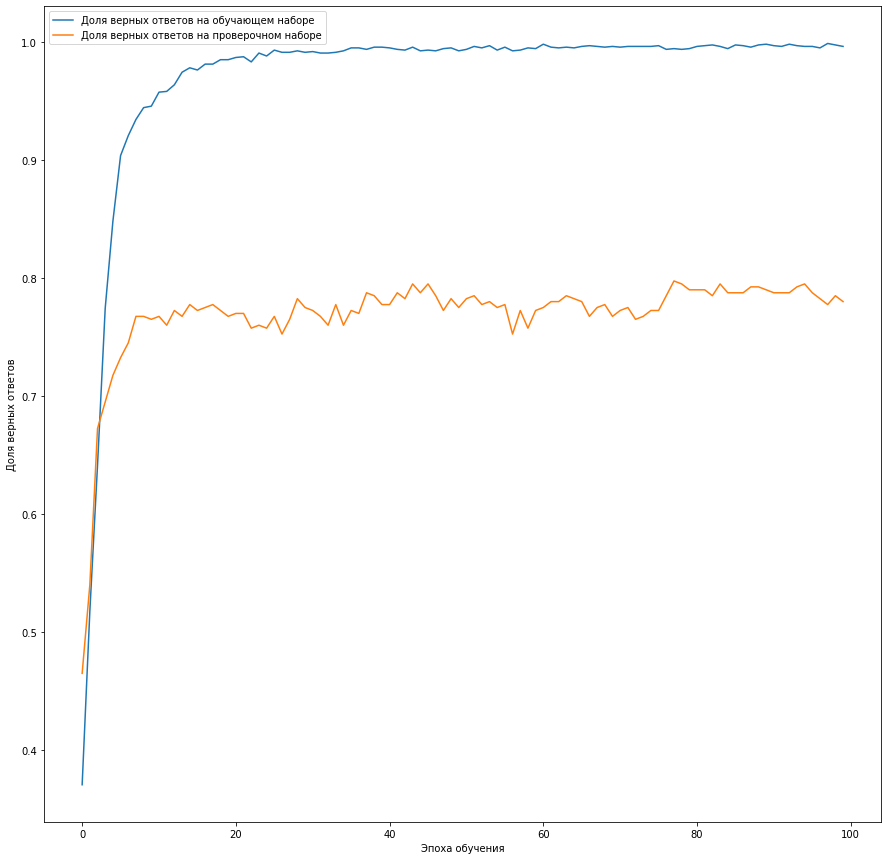

In [269]:
#Создаём полносвязную сеть
model = Sequential()
model.add(Dense(100, input_dim=maxWordsCount, activation="relu"))
model.add(Dropout(0.2)) 
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(nClasses, activation='softmax'))#softmax, sigmoid
time_start = [time.time()]

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке
history = model.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=64,
                    validation_data=(xVal, yVal),
                    verbose=2,
                    callbacks=callbacks)

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [270]:
# 99 эпоха оказалась лучшей
# Загружаем эпоху из дериктории

# Перезаписываем на диск
model.save('/content/99-v_ac_0.9975.hdf5')

## Тестовый датасет

## Определим категорию текста обращения и выведем её в отдельный столбец

In [273]:
df_test.head (3)

,id,Текст Сообщения,Тематика Норм,text_stemmed,text_lemmed,Тип ответственного,Категория
0,843,Помогите начальник Льговского рэс не реагирует...,"нарушения, связанный содержание электросеть ка...","помог начальник льговск рэс реагир жалоб , мал...",помочь начальник льговский рэс реагировать жал...,Администрация,3
1,1422,По фасаду дома по адресу ул. Урицкого 22 прох...,аварийный дерево,по фасад дом адрес ул . урицк 22 проход труб г...,по фасад дом адрес ул . урицкий 22 проходить т...,Комитет,3
2,2782,Агресивные собаки. На радуге там стая из подро...,безнадзорный животное,агресивн собак . на радуг ста подросш щенк звр...,агресивный собака . на радуга стая подрасти ще...,Комитет,3


In [275]:
# Удаляем не нужные колоки 
df_test.drop(df_test.columns[[2,3,4,5]], axis=1, inplace=True)
df_test.head(3) # Смотрим

,id,Текст Сообщения,Категория
0,843,Помогите начальник Льговского рэс не реагирует...,3
1,1422,По фасаду дома по адресу ул. Урицкого 22 прох...,3
2,2782,Агресивные собаки. На радуге там стая из подро...,3


In [ ]:
test.rename(columns={
    'text_processed': 'Текст Сообщения'    
}, inplace=True)
test.head(3) 

,id,Текст Сообщения
0,843,здравствуйте на улице мира было заменено нару...
1,1422,уже вторую неделю не горит уличное освещение
2,2782,не работает освещение во дворе дома а по энерг...


In [277]:
test_mess = np.array(df_test['Текст Сообщения']) # Переводим сообщения в массив
x = tokenizer.texts_to_matrix(test_mess) 

prediction = model.predict(x)

for i in range(len(x)): 
  df_test.loc[i,'Категория'] = np.argmax(prediction[i]) # Присваеваем категорию каждому обращению 
df_test = df_test.astype({'Категория':'Int64'}) 
df_test

,id,Текст Сообщения,Категория
0,843,Помогите начальник Льговского рэс не реагирует...,3
1,1422,По фасаду дома по адресу ул. Урицкого 22 прох...,3
2,2782,Агресивные собаки. На радуге там стая из подро...,1
3,2704,На пересечении улиц Сосновская и Береговая за...,3
4,1,Здравствуйте! Рядом с домом 1 «А» по улице Св...,3
...,...,...,...
995,2619,Между ул.Менделеева д.41 со стороны 1-го подъ...,3
996,2518,"Добрый день! Подскажите пожалуйста, можете Вы...",3
997,2524,опасный канализационный люк,0
998,1577,"Здравствуйте. Не дождавшись ответа, ещё раз х...",3


## Сохраняем результаты классификации тестового набора

In [278]:
# Удаляем колонку с текстом 
df_test.drop(df_test.columns[[1]], axis=1, inplace=True)

In [279]:
df_test

,id,Категория
0,843,3
1,1422,3
2,2782,1
3,2704,3
4,1,3
...,...,...
995,2619,3
996,2518,3
997,2524,0
998,1577,3


In [280]:
# Сохраняем файл в формете .csv без индексов
df_test.to_csv('/content/result.csv', index=False)